In [1]:
# Import packages
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import csv
import yaml
import re
import seaborn as sns
import scipy.cluster.hierarchy as sch
from colorcet import palette
import csv
import yaml
import re
import pandas as pd
import scipy.stats as stats

In [2]:
# Load the processed data
adata = sc.read_h5ad('/Users/aumchampaneri/Databases/Homo sapiens/Hs_Nor-CKD-AKF_scRNA_processed.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 225151 × 29893
    obs: 'orig.ident', 'nCount_RNA', 'SpecimenID', 'LibraryID', 'SampleID', 'Run', 'clusterNumber', 'subclass.l1', 'dataSource', 'diseasetype', 'Race', 'clusterClass', 'organism_ontology_term_id', 'assay_ontology_term_id', 'sampletype', 'disease_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_ontology_term_id', 'tissue_type', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'Age_binned', 'cell_type_ontology_term_id', 'author_cell_type', 'diabetes_history', 'hypertension', 'eGFR', 'is_primary_data', 'disease_category', 'nFeature_RNA', 'percent.mt', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
    var: 'index', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
    uns: 'batch_condition', 'citation', 'def

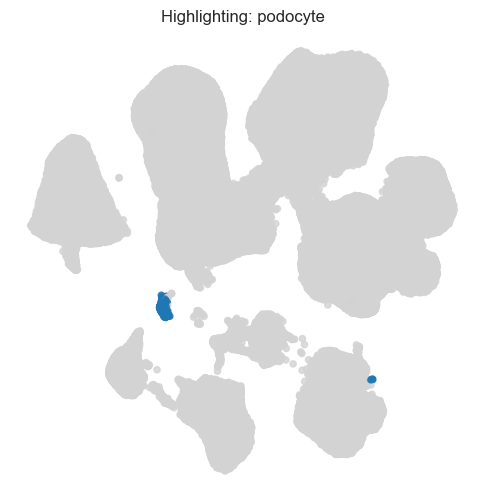

In [13]:
import matplotlib.pyplot as plt

# Grab UMAP coordinates
umap = adata.obsm['X_umap']
cell_types = adata.obs["cell_type"]

# Define your target cell type
target_cell_type = "podocyte"

# Build color list based on condition
colors = ["#1f77b4" if ct == target_cell_type else "lightgray" for ct in cell_types]

# Plot manually
plt.figure(figsize=(6, 6))
plt.scatter(umap[:, 0], umap[:, 1], c=colors, s=20, alpha=0.8)
plt.title(f"Highlighting: {target_cell_type}")
plt.axis("off")
plt.show()


In [3]:
# Load the gene dictionary from the csv file
gene_dict = {}
with open('../complement_gene_dictionary.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        gene_dict[row[0]] = row[1]

# Extract keys and values into separate lists
gene_dict_names = list(gene_dict.keys())
gene_dict_keys = list(gene_dict.values())

# Change the name of some entries in gene_dict_names to fix plotting errors
gene_dict_names = [re.sub(r'\bC2\b', 'C2_ENSG00000166278', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC3\b', 'C3_ENSG00000125730', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC6\b', 'C6_ENSG00000039537', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC7\b', 'C7_ENSG00000112936', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC9\b', 'C9_ENSG00000113600', name) for name in gene_dict_names]

# Load the tissue type dictionary from the yaml file
with open("../Tissue Type Dictionary.yaml", "r") as file:
    cell_type_group = yaml.safe_load(file)

# Map cell types to groups
adata.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_group.items():
    adata.obs.loc[adata.obs['cell_type'].isin(cell_types), 'cell_type_group'] = group

## Test differential expression of complement genes in different disease states

In [30]:
def plot_egfr_distribution(adata, disease_types, show_stats=False, save_path=None, figsize=(8, 6),
                           stats_position=(0.48, 0.13)):
    """
    Plot the distribution of eGFR across different disease types.

    Parameters:
    - adata: AnnData object containing the data.
    - disease_types: List of disease types to include in the plot.
    - show_stats: Boolean indicating whether to show Chi-Square test results on the plot.
    - save_path: Path to save the plot. If None, the plot will be shown.
    - figsize: Tuple indicating the size of the plot (width, height).
    - stats_position: Tuple indicating the position of the stats results on the plot (x, y).

    Returns:
    - None
    """
    # Extract the relevant data and remove rows with unknown eGFR category and 'Reference' diseasetype
    eGFR_data = adata.obs[['diseasetype', 'eGFR']].dropna()
    eGFR_data = eGFR_data[(eGFR_data['eGFR'] != 'unknown') & (eGFR_data['diseasetype'] != 'Reference')]

    # Remove 'Reference' category from the 'diseasetype' column
    eGFR_data['diseasetype'] = eGFR_data['diseasetype'].cat.remove_categories(['Reference'])

    # Filter data by disease types
    if disease_types != 'all':
        eGFR_data = eGFR_data[eGFR_data['diseasetype'].isin(disease_types)]

    # Create a boxplot
    plt.figure(figsize=figsize)
    sns.boxplot(x='diseasetype', y='eGFR', data=eGFR_data)
    plt.title('eGFR Distribution Across Different Disease Types')
    plt.xlabel('Disease Type')
    plt.ylabel('eGFR')
    plt.xticks(rotation=45)

    # Reverse the y-axis
    plt.gca().invert_yaxis()

    if show_stats:
        # Create a contingency table
        contingency_table = pd.crosstab(eGFR_data['diseasetype'], eGFR_data['eGFR'])

        # Perform Chi-Square test
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

        # Add Chi-Square test results to the plot
        plt.text(stats_position[0], stats_position[1], f'Chi-Square test statistic: {chi2:.2f}\n'
                                                       f'p-value: {p:.2e}\n'
                                                       f'Degrees of freedom: {dof}',
                 horizontalalignment='right',
                 verticalalignment='top',
                 transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.5))

    # Save or show plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()


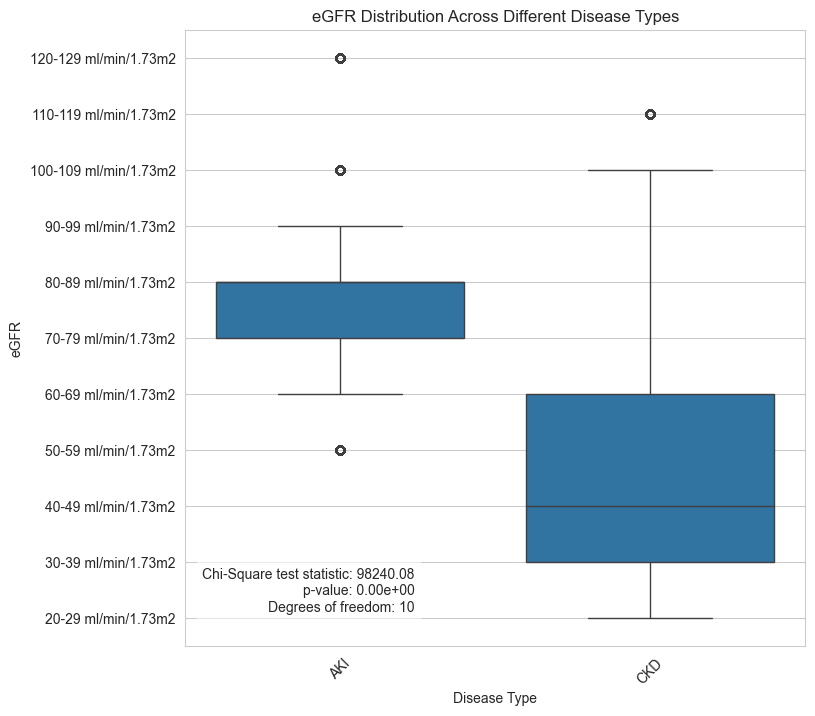

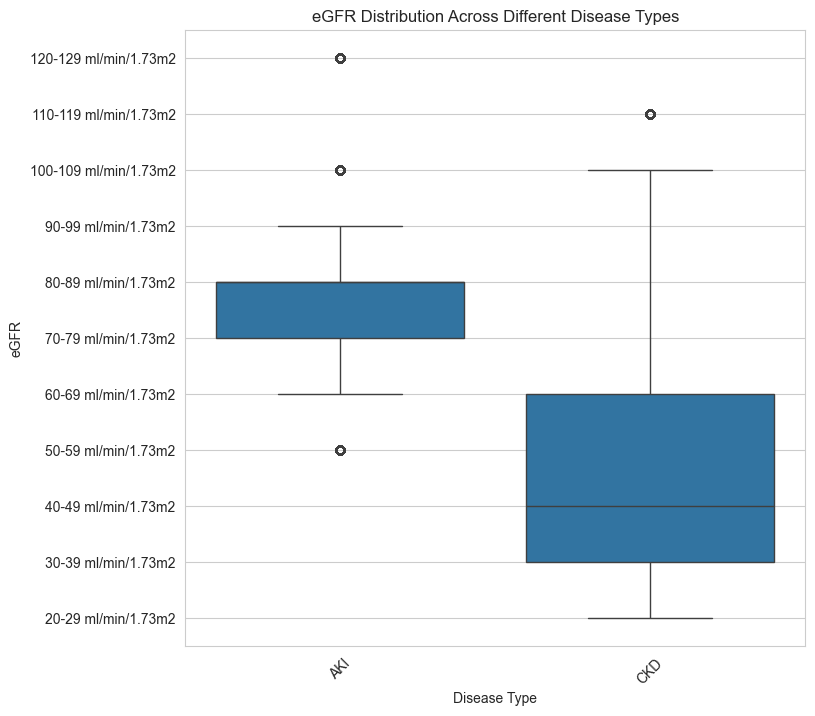

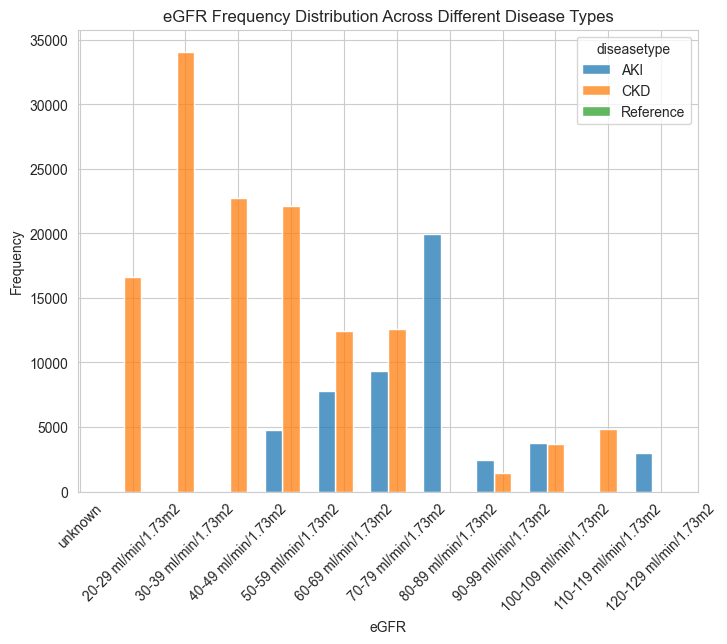